In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

from jsm_routines import SHMF, CSMF, SHMR
import os

>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Tabulating sigma(M,z=0) ...
    From now on, sigma(M,z) is computed by interpolation.
>>> Tabulating z(W) and z(t_lkbk)...
>>> Preparing output redshifts for merger trees ...
    Number of output redshifts =  354, up to z = 20.06
>>> Tabulating Parkinson+08 J(u_res) ...
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...


In [2]:
as_data = np.load("../../data/12_4_0/numpy/acc_surv_mass.npy")
as_red = np.load("../../data/12_4_0/numpy/acc_surv_redshift.npy")

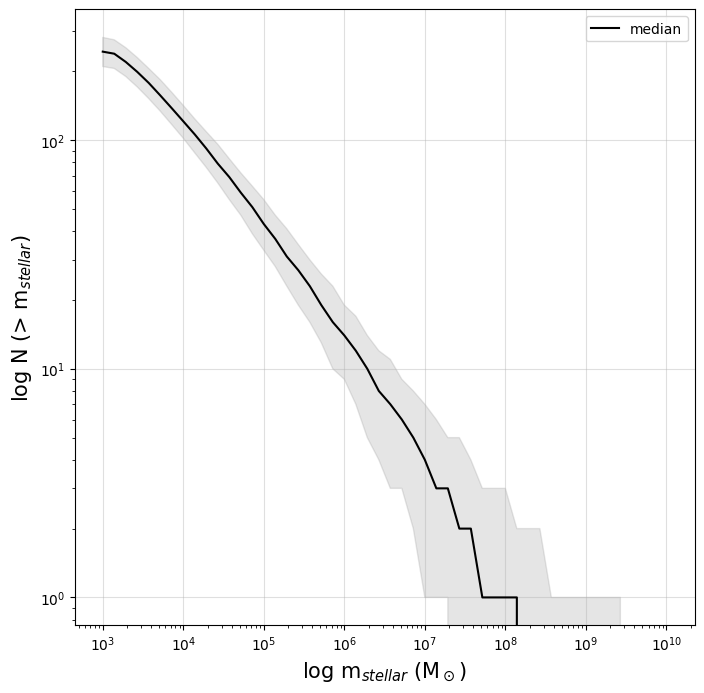

In [3]:
Ms = SHMR(as_data)

surv_massr, surv_CSMF = CSMF(Ms) # accreation mass of the surviving halos!

In [8]:
Nreal = np.array([5,50,100,300,500,1000,2000,3000])

mat = np.zeros(shape=(Nreal.shape[0], 3, 50))


In [9]:
for i,N in enumerate(Nreal):

    choice = np.random.choice(as_data.shape[0], size=N)

    surv_massr, surv_CSMF_i = CSMF(Ms[choice], plot=False) # accreation mass of the surviving halos!
    
    mat[i] = surv_CSMF_i 

In [26]:
colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "cyan"]

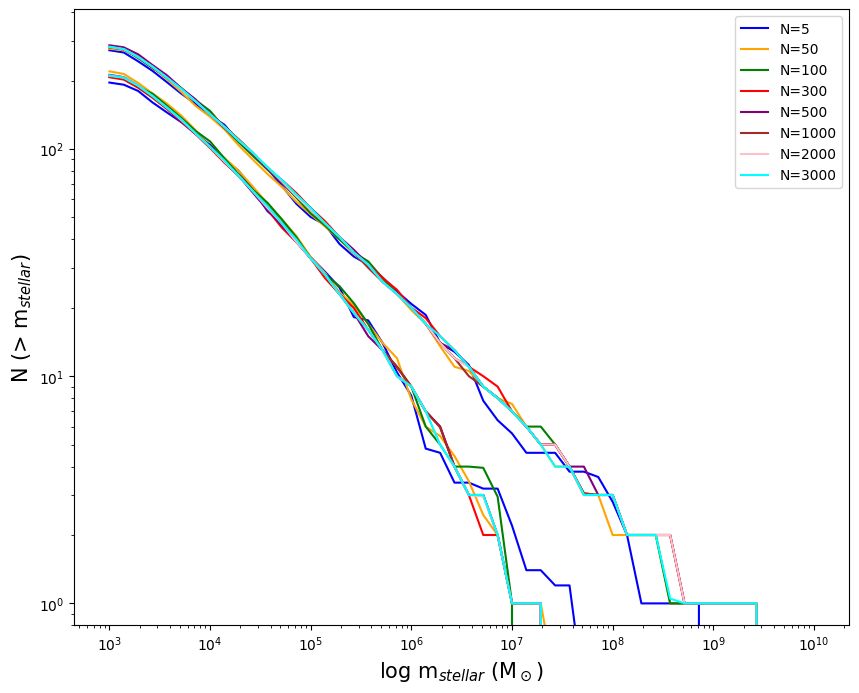

In [29]:
plt.figure(figsize=(10,8))

for i,val in enumerate(mat):
    
    plt.plot(surv_massr, val[0,:], color=colors[i], label="N="+str(Nreal[i]))
    plt.plot(surv_massr, val[2,:], color=colors[i])

plt.yscale("log")
plt.xscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.legend()
plt.ylim(0.8)
plt.show()